### Comparing Online Portfolio Management Algorithms using the Experiments of Agarwal et al. 2007
- In this notebook we analyze the performance of several online portfolio management algorithms using the 'universal-portfolios' package available in Python 
- Our experiments mirror those found in Newton Method Based portfolio management 
- There are two major categories of algorithm under examination: 'Follow the Winner' algorithms, and 'Follow the Loser'
    - Follow the Winner: UP, EG, ONS
    - Follow the Loser: PAMR, CWMR, OLMAR, RMR 
- Benchmark algorithms that we compare performance against are the UCRP, and BCRP
- Extensions: Running more algorithms (Pattern-matching Algorithms)

In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd 
import numpy as np

from universal import tools
from universal import algos
import logging
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.DEBUG)

from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

C:\Users\Josh\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# note what versions we are on:
import sys
print('Python: '+sys.version)
print('Pandas: '+pd.__version__)
import pkg_resources
print('universal-portfolios: '+pkg_resources.get_distribution("universal-portfolios").version)

Python: 2.7.14 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:34:40) [MSC v.1500 64 bit (AMD64)]
Pandas: 0.21.0
universal-portfolios: 0.3.2


#### Data Preprocessing 

In [136]:
date_conv = lambda x: pd.to_datetime(x)

def data_reader(tickers, source, start_date, end_date = None):
    '''
    function that reads data from yahoo finance/ quandl data sources
    inputs:
    tickers -- stock tickers
    source -- 'quandl', 'yahoo'
    start_date -- start of pricing information
    end_date -- end of pricing information 
    returns:
    '''
    data = DataReader(tickers, source, start_date, end_date)
    return data 

def tradable_stocks():
    '''
    List of S&P500 stocks that contain a 30 year price history 
    '''
    return ['AAPL','ABT','AET','ARNC','AXP','BAC','BCR','BDX','CI','CLX','CMC','CMI','CRS','CSX','DIS','DUK','EMR',
            'FDX','GE','GIS','GPC','HON','HPQ','IBM','IFF','INTC','KO','LLY','LNC','MCD','MEI','NEE','NEM','SHW','SLB',
            'TAP','TGT','TXT','WFC','WMB'
           ]

def tradable_csvs():
    '''
    List of S&P500 csv files available. All stocks contain a 30 year price history. This allows one to avoid API call limits
    '''
    return ['AAPL.csv','ABT.csv','AET.csv','ARNC.csv','AXP.csv','BAC.csv','BCR.csv','BDX.csv','CI.csv','CLX.csv','CMC.csv',
            'CMI.csv','CRS.csv','CSX.csv','DIS.csv','DUK.csv','EMR.csv','FDX.csv','GE.csv','GIS.csv','GPC.csv','HON.csv',
            'HPQ.csv','IBM.csv','IFF.csv','INTC.csv','KO.csv','LLY.csv','LNC.csv','MCD.csv','MEI.csv','NEE.csv','NEM.csv','SHW.csv',
            'SLB.csv','TAP.csv','TGT.csv','TXT.csv','WFC.csv','WMB.csv'
           ]

def stock_df(n_stocks, start_date, end_date, csv = None):
    '''
    function that takes as input a portolio size n and returns a dataframe that contains a number of stocks  
    '''
    # select n stock csv files 
    if csv != None:
        filenames = csv
    else:
        filenames = tradable_csvs()[0:n_stocks]
    # construct empty data frame to hold financial data
    ret_df = pd.DataFrame()
    price_df = pd.DataFrame()
    for f in filenames:
        series = pd.read_csv('C://Users//Josh//Desktop//ACTSC972_project//data//' + f)
        series['Date'] = series['Date'].apply(date_conv)
        series = series.set_index('Date')
        series = series['Adj Close']
        series = series.loc[(series.index<=end_date) & (series.index >= start_date)].astype('float')
        series_ret = series.iloc[0:-1].as_matrix()/series.iloc[1:].as_matrix()
        ret_df[f.split('.')[0]] = series_ret
        price_df[f.split('.')[0]] = series
    return ret_df, price_df  

In [116]:
# construct data frame that contains returns data for 40 stocks 
n = 40
start_date = pd.to_datetime('2010-01-10')
end_date = pd.to_datetime('2017-09-20')
returns_df, price_df = stock_df(n, start_date, end_date)

In [7]:
returns_df.head()

,AAPL,ABT,AET,ARNC,AXP,BAC,BCR,BDX,CI,CLX,...,MEI,NEE,NEM,SHW,SLB,TAP,TGT,TXT,WFC,WMB
0,1.011506,1.002900,1.069585,1.124355,0.986911,1.034841,1.009943,1.015016,1.022715,0.998535,...,1.009804,1.024941,1.034213,1.003534,1.015233,0.996458,1.017025,1.006563,1.025641,1.030262
1,0.986091,0.990595,0.995447,0.971214,0.996916,0.984356,0.973738,0.996774,1.002469,0.991927,...,0.972045,0.996505,0.995282,0.987371,0.982216,0.996031,1.000000,1.019599,0.982505,0.999084
2,1.005825,0.998916,0.978988,1.010752,0.987582,0.988109,0.988988,1.005971,0.991297,1.000646,...,1.016234,1.029794,1.006815,0.994218,0.993828,0.994736,0.984830,0.917947,0.985857,1.005991
3,1.016996,0.997477,1.001595,1.011517,1.006841,1.034440,1.011256,1.009831,0.998100,1.011440,...,1.027523,0.989317,1.017013,1.022639,1.006494,1.009075,0.998605,1.041591,1.032407,1.015442
4,0.957636,0.987367,0.960196,1.000640,0.986732,0.996323,0.985566,0.987062,0.971519,0.995283,...,0.996675,0.993319,0.982866,0.996968,0.998590,1.013459,0.979882,0.952132,0.992928,0.925108


In [8]:
price_df.head()

,AAPL,ABT,AET,ARNC,AXP,BAC,BCR,BDX,CI,CLX,...,MEI,NEE,NEM,SHW,SLB,TAP,TGT,TXT,WFC,WMB
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-11,27.003820,21.532736,30.029846,36.411705,36.933857,15.913613,77.263260,67.476524,37.181705,48.520897,...,10.687086,40.495270,44.774933,53.846889,60.504143,37.448517,40.794662,21.023281,23.909105,12.995709
2010-01-12,26.696650,21.470472,28.076166,32.384525,37.423706,15.377831,76.502563,66.478264,36.355896,48.592091,...,10.583330,39.509838,43.293732,53.657272,59.596336,37.581631,40.111771,20.886204,23.311371,12.613988
2010-01-13,27.073221,21.674320,28.204578,33.344368,37.539482,15.622222,78.565857,66.693405,36.266354,48.987583,...,10.887694,39.648411,43.498966,54.343559,60.675404,37.731388,40.111771,20.484732,23.726467,12.625559
2010-01-14,26.916422,21.697838,28.809944,32.989651,38.011509,15.810215,79.440628,66.297562,36.584740,48.955956,...,10.713769,38.501308,43.204514,54.659615,61.052204,37.931072,40.729626,22.315823,24.066833,12.550372
2010-01-15,26.466595,21.752720,28.764076,32.614048,37.753227,15.283833,78.556381,65.652153,36.654381,48.402237,...,10.426793,38.917042,42.481766,53.449577,60.658264,37.589947,40.786522,21.424755,23.311371,12.359512


Text(0.5,1,u'Daily Stock Returns')

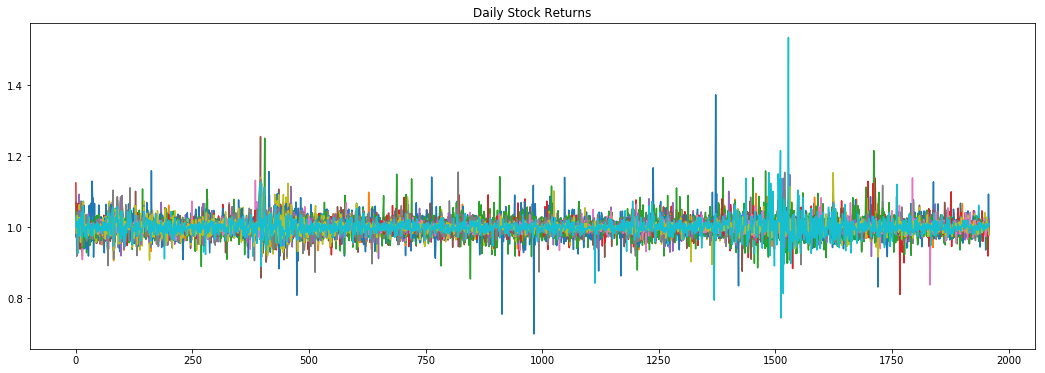

In [9]:
returns_df.plot(figsize=(18,6), legend = False)
plt.title('Daily Stock Returns')

Text(0.5,1,u'Adjusted Closing Price')

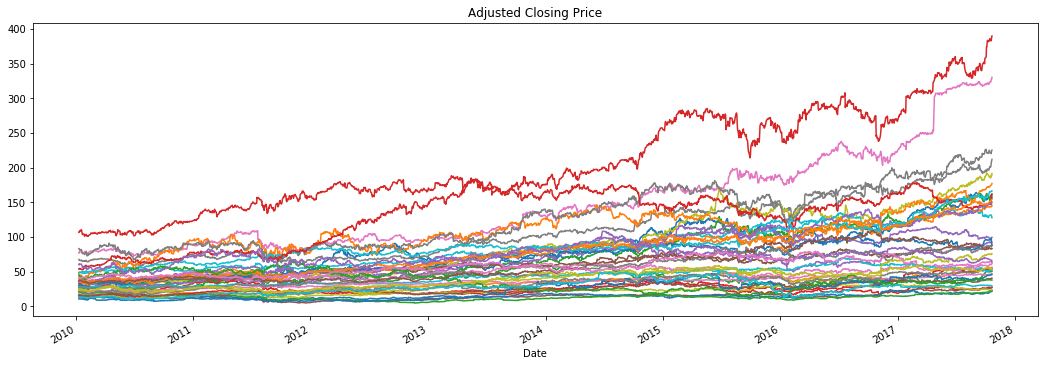

In [10]:
price_df.plot(figsize = (18,6), legend = False)
plt.title('Adjusted Closing Price')

In [11]:
# stocks in data frame
price_df.columns

Index([u'AAPL', u'ABT', u'AET', u'ARNC', u'AXP', u'BAC', u'BCR', u'BDX', u'CI',
       u'CLX', u'CMC', u'CMI', u'CRS', u'CSX', u'DIS', u'DUK', u'EMR', u'FDX',
       u'GE', u'GIS', u'GPC', u'HON', u'HPQ', u'IBM', u'IFF', u'INTC', u'KO',
       u'LLY', u'LNC', u'MCD', u'MEI', u'NEE', u'NEM', u'SHW', u'SLB', u'TAP',
       u'TGT', u'TXT', u'WFC', u'WMB'],
      dtype='object')

In [12]:
#### Initiate Algorithms for Testing 

algorithms = [
algos.BCRP(),
algos.EG(),
algos.ONS(),
algos.OLMAR(window=5, eps = 10),
algos.PAMR(),
algos.CWMR(),
algos.Anticor()
]

# need to fix bug in code for UP algorithm and BNN algorithm

#### Experiment 1: Mean APY Versus Portfolio Size 

In [13]:
portfolio_size = [10, 15, 20, 25, 30, 35, 40]
algorithms_col = ['BCRP', 'EG', 'ONS', 'OLMAR', 'PAMR', 'CWMR', 'ANTICOR']
exp1_df = pd.DataFrame(data = None, index = portfolio_size, columns = algorithms_col)
#apy = np.zeros((len(portfolio_size), len(algorithms_col)))

In [14]:
exp1_df.head()

,BCRP,EG,ONS,OLMAR,PAMR,CWMR,ANTICOR
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
for i in range(len(algorithms)):
    for j in range(len(portfolio_size)):
        data = returns_df.iloc[:,0:portfolio_size[j]]
        result = algorithms[i].run(data)
        mapy = result.annualized_return/7
        exp1_df.loc[portfolio_size[j], algorithms_col[i]] = mapy

2017-12-06 22:52:41,017 Running BCRP...
2017-12-06 22:52:41,184 BCRP finished successfully.
2017-12-06 22:52:41,223 Running BCRP...
2017-12-06 22:52:41,470 BCRP finished successfully.
2017-12-06 22:52:41,503 Running BCRP...
2017-12-06 22:52:41,750 BCRP finished successfully.
2017-12-06 22:52:41,785 Running BCRP...
2017-12-06 22:52:42,032 BCRP finished successfully.
2017-12-06 22:52:42,069 Running BCRP...
2017-12-06 22:52:42,372 BCRP finished successfully.
2017-12-06 22:52:42,415 Running BCRP...
2017-12-06 22:52:42,734 BCRP finished successfully.
2017-12-06 22:52:42,776 Running BCRP...
2017-12-06 22:52:43,260 BCRP finished successfully.
2017-12-06 22:52:43,309 Running EG...
2017-12-06 22:52:43,331 Progress: 0%...
2017-12-06 22:52:43,697 Progress: 10%...
2017-12-06 22:52:44,105 Progress: 20%...
2017-12-06 22:52:44,467 Progress: 30%...
2017-12-06 22:52:44,835 Progress: 40%...
2017-12-06 22:52:45,190 Progress: 50%...
2017-12-06 22:52:45,572 Progress: 60%...
2017-12-06 22:52:45,948 Progress

2017-12-06 22:55:40,075 Progress: 30%...
2017-12-06 22:55:40,859 Progress: 40%...
2017-12-06 22:55:41,566 Progress: 50%...
2017-12-06 22:55:42,312 Progress: 60%...
2017-12-06 22:55:43,003 Progress: 70%...
2017-12-06 22:55:43,707 Progress: 80%...
2017-12-06 22:55:44,440 Progress: 90%...
2017-12-06 22:55:45,138 OLMAR finished successfully.
2017-12-06 22:55:45,171 Running OLMAR...
2017-12-06 22:55:45,901 Progress: 10%...
2017-12-06 22:55:46,625 Progress: 20%...
2017-12-06 22:55:47,381 Progress: 30%...
2017-12-06 22:55:48,095 Progress: 40%...
2017-12-06 22:55:48,785 Progress: 50%...
2017-12-06 22:55:49,459 Progress: 60%...
2017-12-06 22:55:50,153 Progress: 70%...
2017-12-06 22:55:50,832 Progress: 80%...
2017-12-06 22:55:51,516 Progress: 90%...
2017-12-06 22:55:52,196 OLMAR finished successfully.
2017-12-06 22:55:52,240 Running OLMAR...
2017-12-06 22:55:52,927 Progress: 10%...
2017-12-06 22:55:53,631 Progress: 20%...
2017-12-06 22:55:54,299 Progress: 30%...
2017-12-06 22:55:54,950 Progress:

2017-12-06 22:57:11,085 Progress: 0%...
2017-12-06 22:57:12,107 Progress: 10%...
2017-12-06 22:57:13,119 Progress: 20%...
2017-12-06 22:57:14,226 Progress: 30%...
2017-12-06 22:57:15,252 Progress: 40%...
2017-12-06 22:57:16,335 Progress: 50%...
2017-12-06 22:57:17,444 Progress: 60%...
2017-12-06 22:57:18,450 Progress: 70%...
2017-12-06 22:57:19,526 Progress: 80%...
2017-12-06 22:57:20,538 Progress: 90%...
2017-12-06 22:57:21,607 CWMR finished successfully.
2017-12-06 22:57:21,648 Running CWMR...
2017-12-06 22:57:21,688 Progress: 0%...
2017-12-06 22:57:22,674 Progress: 10%...
2017-12-06 22:57:23,638 Progress: 20%...
2017-12-06 22:57:24,723 Progress: 30%...
2017-12-06 22:57:25,753 Progress: 40%...
2017-12-06 22:57:26,739 Progress: 50%...
2017-12-06 22:57:27,756 Progress: 60%...
2017-12-06 22:57:28,766 Progress: 70%...
2017-12-06 22:57:29,795 Progress: 80%...
2017-12-06 22:57:30,769 Progress: 90%...
2017-12-06 22:57:31,749 CWMR finished successfully.
2017-12-06 22:57:31,792 Running CWMR..

In [19]:
exp1_df

,BCRP,EG,ONS,OLMAR,PAMR,CWMR,ANTICOR
10,0.00550539,0.00428842,0.0336124,9.40036,3.86237,3.85166,0.311761
15,0.00706646,0.00525139,0.0518024,25.7361,7.9264,7.9795,0.491071
20,0.00706737,0.00477668,0.0591869,35.2793,10.2937,10.3054,0.524163
25,0.00774586,0.0046614,0.0654898,48.6029,12.5507,12.5787,0.554212
30,0.007757,0.00461916,0.0757115,61.0318,15.3558,15.3907,0.545239
35,0.0130066,0.00549139,0.0850243,180.621,33.487,33.8919,0.642586
40,0.014812,0.00578551,0.0994443,316.169,49.1954,49.6404,0.699297


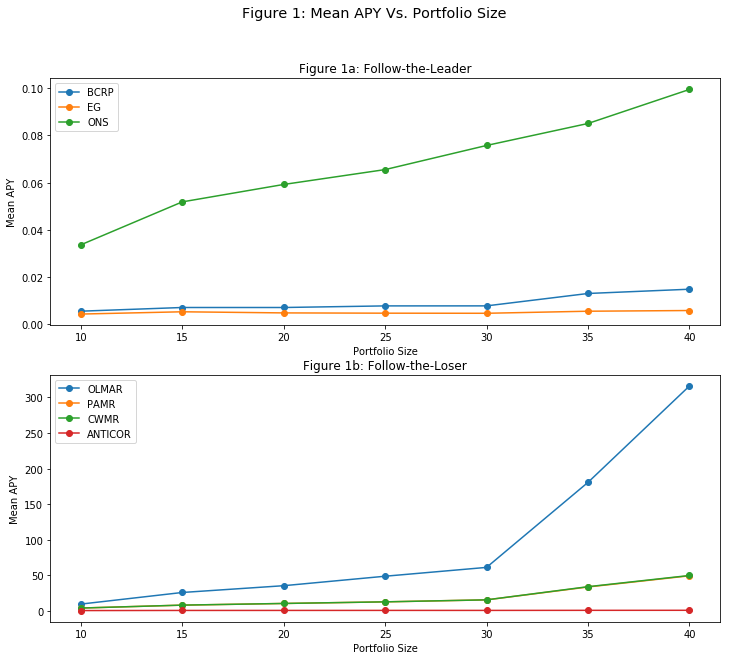

In [24]:
plt.figure(figsize = (12,10))
plt.suptitle('Figure 1: Mean APY Vs. Portfolio Size', fontsize="x-large")
plt.subplot(2,1,1)
plt.plot(portfolio_size, exp1_df['BCRP'], '-o')
plt.plot(portfolio_size, exp1_df['EG'], '-o')
plt.plot(portfolio_size, exp1_df['ONS'], '-o')
plt.title('Figure 1a: Follow-the-Leader')
plt.legend(['BCRP', 'EG', 'ONS'])
plt.xlabel('Portfolio Size')
plt.ylabel('Mean APY')
plt.subplot(2,1,2)
plt.plot(portfolio_size, exp1_df['OLMAR'], '-o')
plt.plot(portfolio_size, exp1_df['PAMR'], '-o')
plt.plot(portfolio_size, exp1_df['CWMR'], '-o')
plt.plot(portfolio_size, exp1_df['ANTICOR'], '-o')
plt.legend(['OLMAR', 'PAMR', 'CWMR', 'ANTICOR'])
plt.xlabel('Portfolio Size')
plt.ylabel('Mean APY')
plt.title('Figure 1b: Follow-the-Loser')
plt.show()
plt.show()

#### Experiment 2: Total Wealth Achieved in a 10 Stock Portfolio 

In [26]:
n_stock = 10
return2_df, price2_df = stock_df(n_stock,start_date)

Text(0.5,1,u'Figure 3: 10 Stock Portfolio')

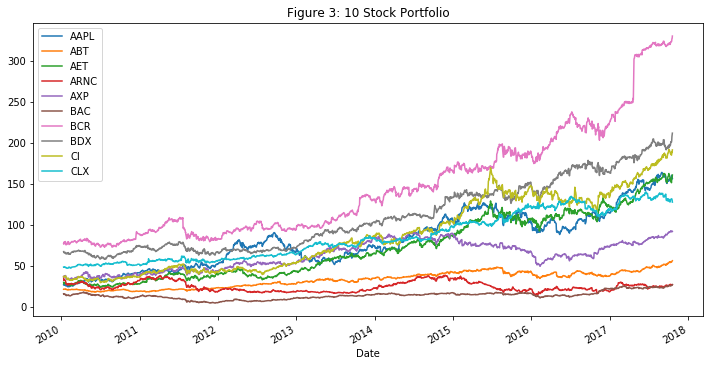

In [369]:
price2_df.plot(figsize = (12,6))
plt.title('Figure 3: 10 Stock Portfolio')

In [30]:
price2_df.columns

Index([u'AAPL', u'ABT', u'AET', u'ARNC', u'AXP', u'BAC', u'BCR', u'BDX', u'CI',
       u'CLX'],
      dtype='object')

In [31]:
metrics = ['results', 
           'profit', 
           'sharpe', 
           'information_ratio', 
           'annualized_return', 
           'drawdown', 
           'win_pct']

In [32]:
exp2_df = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [33]:
exp2_df

,results,profit,sharpe,information_ratio,annualized_return,drawdown,win_pct
BCRP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OLMAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAMR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CWMR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANTICOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# run each algorithm on data set 
for i in range(len(algorithms_col)):
    exp2_df.loc[algorithms_col[i], 'results'] = algorithms[i].run(return2_df)

2017-12-06 23:03:09,467 Running BCRP...
2017-12-06 23:03:09,648 BCRP finished successfully.
2017-12-06 23:03:09,690 Running EG...
2017-12-06 23:03:09,713 Progress: 0%...
2017-12-06 23:03:10,128 Progress: 10%...
2017-12-06 23:03:10,489 Progress: 20%...
2017-12-06 23:03:10,858 Progress: 30%...
2017-12-06 23:03:11,239 Progress: 40%...
2017-12-06 23:03:11,621 Progress: 50%...
2017-12-06 23:03:12,061 Progress: 60%...
2017-12-06 23:03:12,444 Progress: 70%...
2017-12-06 23:03:12,825 Progress: 80%...
2017-12-06 23:03:13,296 Progress: 90%...
2017-12-06 23:03:13,698 EG finished successfully.
2017-12-06 23:03:13,726 Running ONS...
2017-12-06 23:03:13,749 Progress: 0%...
2017-12-06 23:03:14,927 Progress: 10%...
2017-12-06 23:03:16,016 Progress: 20%...
2017-12-06 23:03:17,115 Progress: 30%...
2017-12-06 23:03:18,246 Progress: 40%...
2017-12-06 23:03:19,391 Progress: 50%...
2017-12-06 23:03:20,513 Progress: 60%...
2017-12-06 23:03:21,687 Progress: 70%...
2017-12-06 23:03:22,842 Progress: 80%...
2017

In [46]:
def statistics(exp_df):
    '''
    Function that takes as input an experiment data frame and unpacks the results for each algorithm into their 
    respective columns
    '''
    for ind in exp_df.index:
        exp_df.loc[ind, 'profit'] = exp_df.loc[ind, 'results'].profit_factor
        exp_df.loc[ind, 'sharpe'] = exp_df.loc[ind, 'results'].sharpe
        exp_df.loc[ind, 'information_ratio'] = exp_df.loc[ind, 'results'].information
        exp_df.loc[ind, 'annualized_return'] = exp_df.loc[ind, 'results'].annualized_return
        exp_df.loc[ind, 'drawdown'] = exp_df.loc[ind, 'results'].max_drawdown
        exp_df.loc[ind, 'win_pct'] = exp_df.loc[ind, 'results'].winning_pct
    return exp_df

In [64]:
exp2_df = statistics(exp2_df)

In [94]:
def results_plot(exp_df, title, sub_title, figsize):
    '''
    Function that takes as input a data frame of results and produces a 6 panel image containing histograms for the following:
    profit factor, sharpe ratio, information ratio, annualized return, maximum drawdown, and win percentage
    inputs:
    exp_df -- data frame containing experimental results
    title -- main title of image
    sub_title -- titles of subplots (ordered)
    figsize -- size of output image
    '''
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = figsize)
    f.suptitle(title)
    axs = [ax1, ax2, ax3, ax4, ax5, ax6]
    for i in range(len(axs)):
        axs[i].bar(exp_df.index, exp_df.iloc[:,i+1], width = 1.0, color = sns.light_palette("navy", reverse=True))
        axs[i].set_title(sub_title[i])
    plt.show()

In [95]:
exp2_df

,results,profit,sharpe,information_ratio,annualized_return,drawdown,win_pct
BCRP,<universal.result.AlgoResult object at 0x00000...,1.0247,0.137662,0.0665127,0.0385377,0.172153,0.520429
EG,<universal.result.AlgoResult object at 0x00000...,1.02245,0.126345,-4.30046,0.030019,0.137012,0.519408
ONS,<universal.result.AlgoResult object at 0x00000...,1.17261,0.9146,4.23585,0.235286,0.113453,0.540858
OLMAR,<universal.result.AlgoResult object at 0x00000...,7.17207,10.42,13.8001,65.8025,0.102574,0.775792
PAMR,<universal.result.AlgoResult object at 0x00000...,4.35281,7.80318,10.3926,27.0366,0.165371,0.730848
CWMR,<universal.result.AlgoResult object at 0x00000...,4.33754,7.80616,10.3887,26.9616,0.165293,0.731359
ANTICOR,<universal.result.AlgoResult object at 0x00000...,2.02745,4.0166,6.01189,2.18233,0.0822555,0.623085


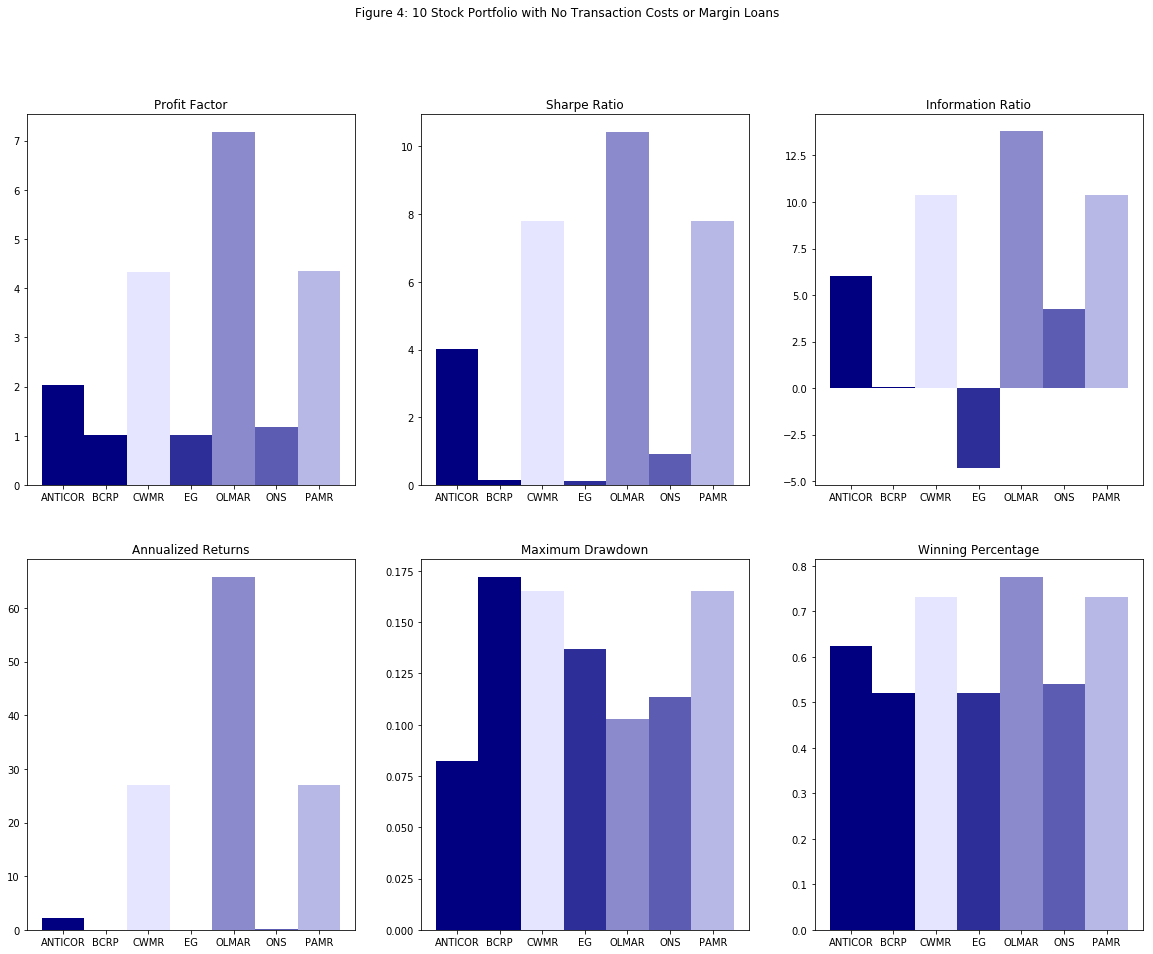

In [96]:
title = 'Figure 4: 10 Stock Portfolio with No Transaction Costs or Margin Loans'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
results_plot(exp2_df, title = title, sub_title = sub_title, figsize = (20,15))

#### Experiment 3: 10 Stocks with Transaction Costs 

In [107]:
# Add fees of 2% per transaction 
for res in exp2_df.results:
    res.fee = 0.01

In [110]:
exp3_df = statistics(exp2_df)

In [111]:
title = 'Figure 5: 10 Stock Portfolio with Transcation Costs'

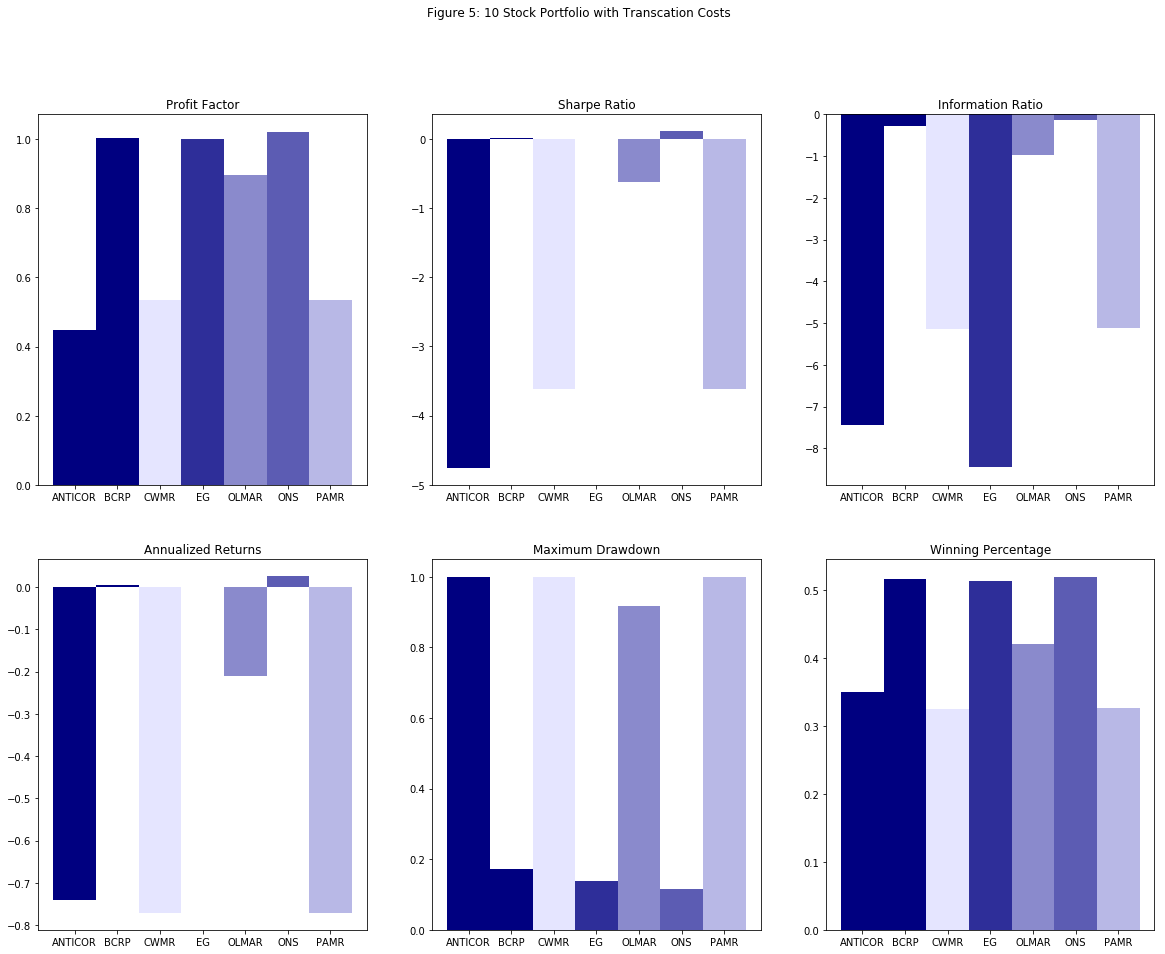

In [112]:
results_plot(exp3_df, title = title, sub_title = sub_title, figsize = (20,15))

#### Experiment 4: Financial Crisis Performance 

In [119]:
n_stocks = 10 
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2011-01-05')
crisis_returns, crisis_prices = stock_df(n_stocks, start_date, end_date)

Text(0.5,1,u'Figure 6: Adjusting Closing Prices During 2008-2009 Financial Crisis')

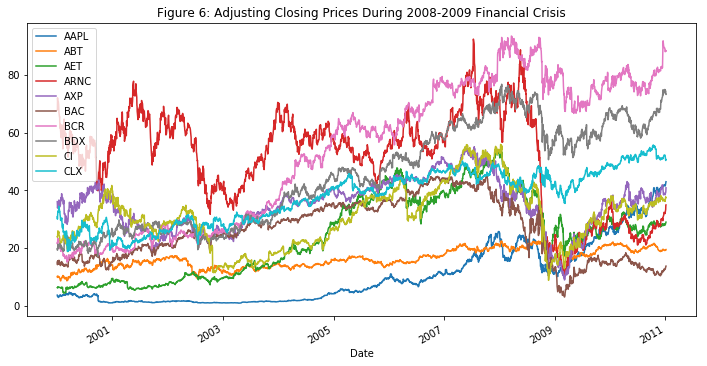

In [365]:
crisis_prices.plot(figsize = (12,6))
plt.title('Figure 6: Adjusting Closing Prices During 2008-2009 Financial Crisis')

In [127]:
exp4_df = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [128]:
# run each algorithm on data set 
for i in range(len(algorithms_col)):
    exp4_df.loc[algorithms_col[i], 'results'] = algorithms[i].run(crisis_returns)

2017-12-07 11:05:59,690 Running BCRP...
2017-12-07 11:05:59,869 BCRP finished successfully.
2017-12-07 11:05:59,903 Running EG...
2017-12-07 11:05:59,923 Progress: 0%...
2017-12-07 11:06:00,460 Progress: 10%...
2017-12-07 11:06:00,984 Progress: 20%...
2017-12-07 11:06:01,411 Progress: 30%...
2017-12-07 11:06:01,813 Progress: 40%...
2017-12-07 11:06:02,232 Progress: 50%...
2017-12-07 11:06:02,608 Progress: 60%...
2017-12-07 11:06:03,013 Progress: 70%...
2017-12-07 11:06:03,410 Progress: 80%...
2017-12-07 11:06:03,796 Progress: 90%...
2017-12-07 11:06:04,190 EG finished successfully.
2017-12-07 11:06:04,214 Running ONS...
2017-12-07 11:06:04,239 Progress: 0%...
2017-12-07 11:06:05,792 Progress: 10%...
2017-12-07 11:06:07,309 Progress: 20%...
2017-12-07 11:06:08,957 Progress: 30%...
2017-12-07 11:06:10,713 Progress: 40%...
2017-12-07 11:06:12,451 Progress: 50%...
2017-12-07 11:06:14,348 Progress: 60%...
2017-12-07 11:06:16,092 Progress: 70%...
2017-12-07 11:06:17,782 Progress: 80%...
2017

In [129]:
exp4_df = statistics(exp4_df)

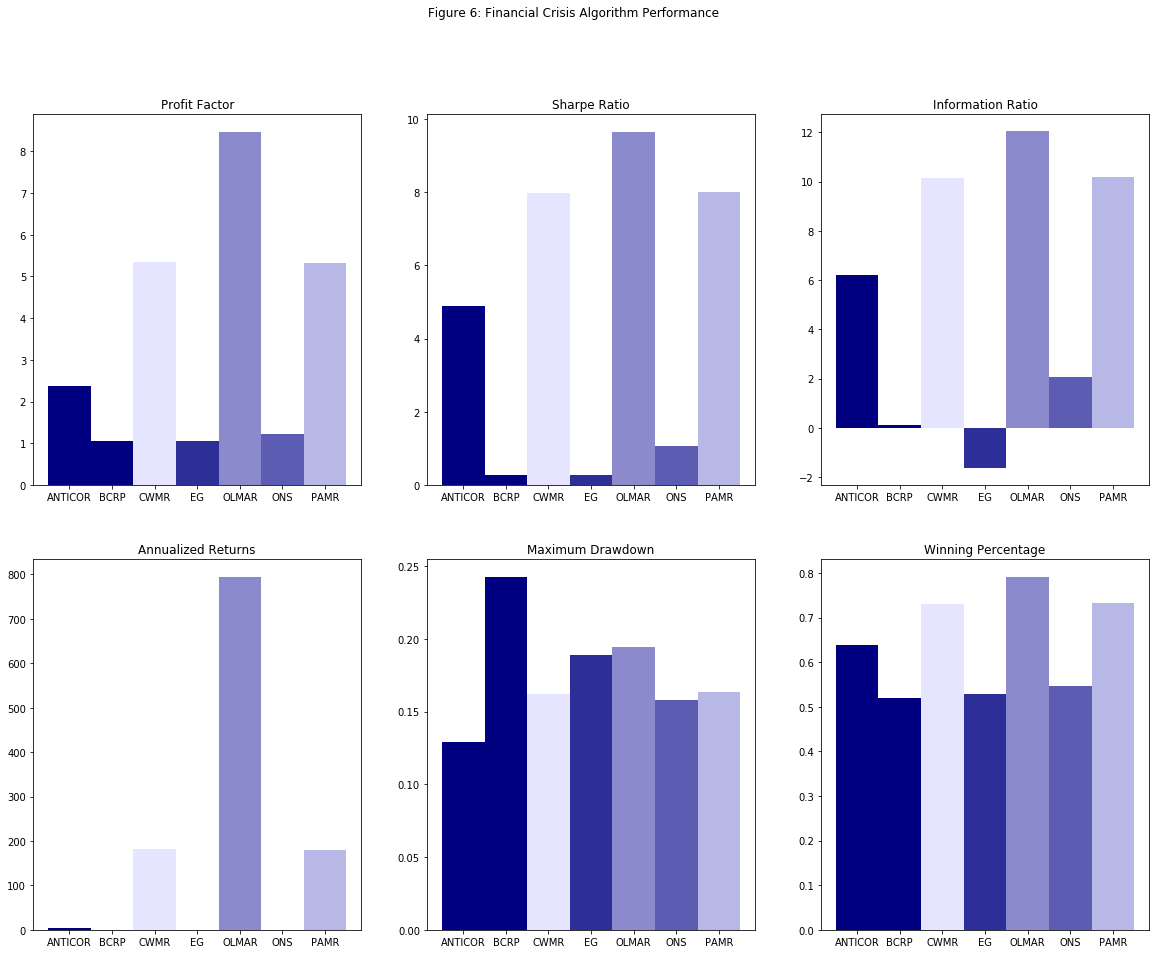

In [132]:
# plot results 
title = 'Figure 6: Financial Crisis Algorithm Performance'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
figsize = (20,15)
results_plot(exp4_df, title= title, sub_title=sub_title, figsize = (20,15))

#### Experiment 5: Tracking the Best Stock - APPL and IBM 

In [263]:
csvs = ['AAPL.csv', 'IBM.csv' ]
start_date = pd.to_datetime('2012-01-10')
end_date = pd.to_datetime('2017-09-20')
return5_df, price5_df = stock_df(n_stocks = 2, start_date= start_date, end_date = end_date, csv = csvs)

Text(0.5,1,u'Figure 7: AAPL and IBM Stock Performance')

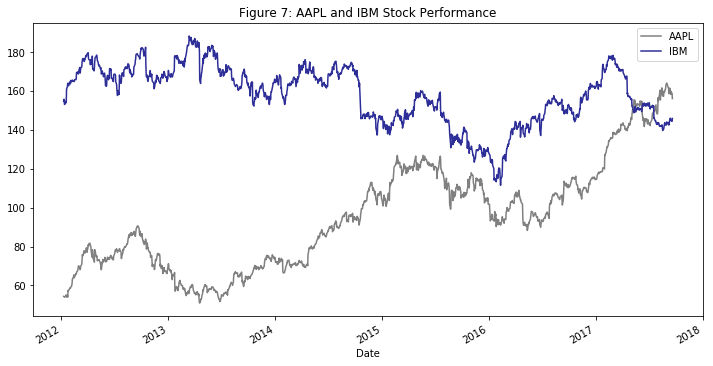

In [368]:
price5_df.plot(color = ['grey', sns.light_palette("navy", reverse=True)[1]] , 
                       figsize = (12,6))
plt.title('Figure 7: AAPL and IBM Stock Performance')

In [265]:
exp5_df = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [266]:
# run algorithm on returns data 
# run each algorithm on data set 
for i in range(len(algorithms_col)):
    exp5_df.loc[algorithms_col[i], 'results'] = algorithms[i].run(return5_df)

2017-12-07 12:39:38,997 Running BCRP...
2017-12-07 12:39:39,016 BCRP finished successfully.
2017-12-07 12:39:39,033 Running EG...
2017-12-07 12:39:39,045 Progress: 0%...
2017-12-07 12:39:39,301 Progress: 10%...
2017-12-07 12:39:39,509 Progress: 20%...
2017-12-07 12:39:39,720 Progress: 30%...
2017-12-07 12:39:39,923 Progress: 40%...
2017-12-07 12:39:40,119 Progress: 50%...
2017-12-07 12:39:40,329 Progress: 60%...
2017-12-07 12:39:40,535 Progress: 70%...
2017-12-07 12:39:40,740 Progress: 80%...
2017-12-07 12:39:40,940 Progress: 90%...
2017-12-07 12:39:41,141 EG finished successfully.
2017-12-07 12:39:41,157 Running ONS...
2017-12-07 12:39:41,168 Progress: 0%...
2017-12-07 12:39:41,486 Progress: 10%...
2017-12-07 12:39:41,780 Progress: 20%...
2017-12-07 12:39:42,085 Progress: 30%...
2017-12-07 12:39:42,377 Progress: 40%...
2017-12-07 12:39:42,670 Progress: 50%...
2017-12-07 12:39:42,960 Progress: 60%...
2017-12-07 12:39:43,257 Progress: 70%...
2017-12-07 12:39:43,548 Progress: 80%...
2017

In [255]:
# incorporate transcation costs 
for res in exp5_df.results:
    res.fee = 0.01

In [256]:
exp5_df = statistics(exp5_df)

In [332]:
def plot_weights(exp_df, best_stock, title, colors, figsize):
    '''
    Function that takes as input a data frame containing experimental results, image title, and image subtitles and returns 
    graphs that display algorithm weights over the backtest period 
    inputs:
    exp_df -- results of experiment
    best_stock -- ticker of the best stock in the experiment 
    title -- main title over image panel
    subtitle -- image subtitles
    legend -- stock tickers
    '''
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize =figsize)
    f.suptitle(title, y = 1.01, fontsize = 14)
    axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    # plot a common image showing how best stock is tracked 
    for i in range(exp_df.shape[0]):
   #     axs[0].set_color_cycle(sns.light_palette("navy", reverse=True)[1])
        axs[0].plot(exp_df.results[i].weights.loc[:,best_stock], color = sns.light_palette("navy", reverse=True)[1])
        axs[0].set_xlabel('Trading Days')
        axs[0].set_ylabel('Holdings')
        axs[0].set_title('Tracking the Best Stock - ' + best_stock)
    for i in range(1, len(axs)):
        axs[i].set_color_cycle(colors)
        axs[i].plot(exp_df.results[i-1].weights)
        axs[i].set_xlabel('Trading Days')
        axs[i].set_ylabel('Holdings')
        axs[i].set_title(exp_df.index[i-1])
        axs[i].legend(exp_df.results[0].weights.columns)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

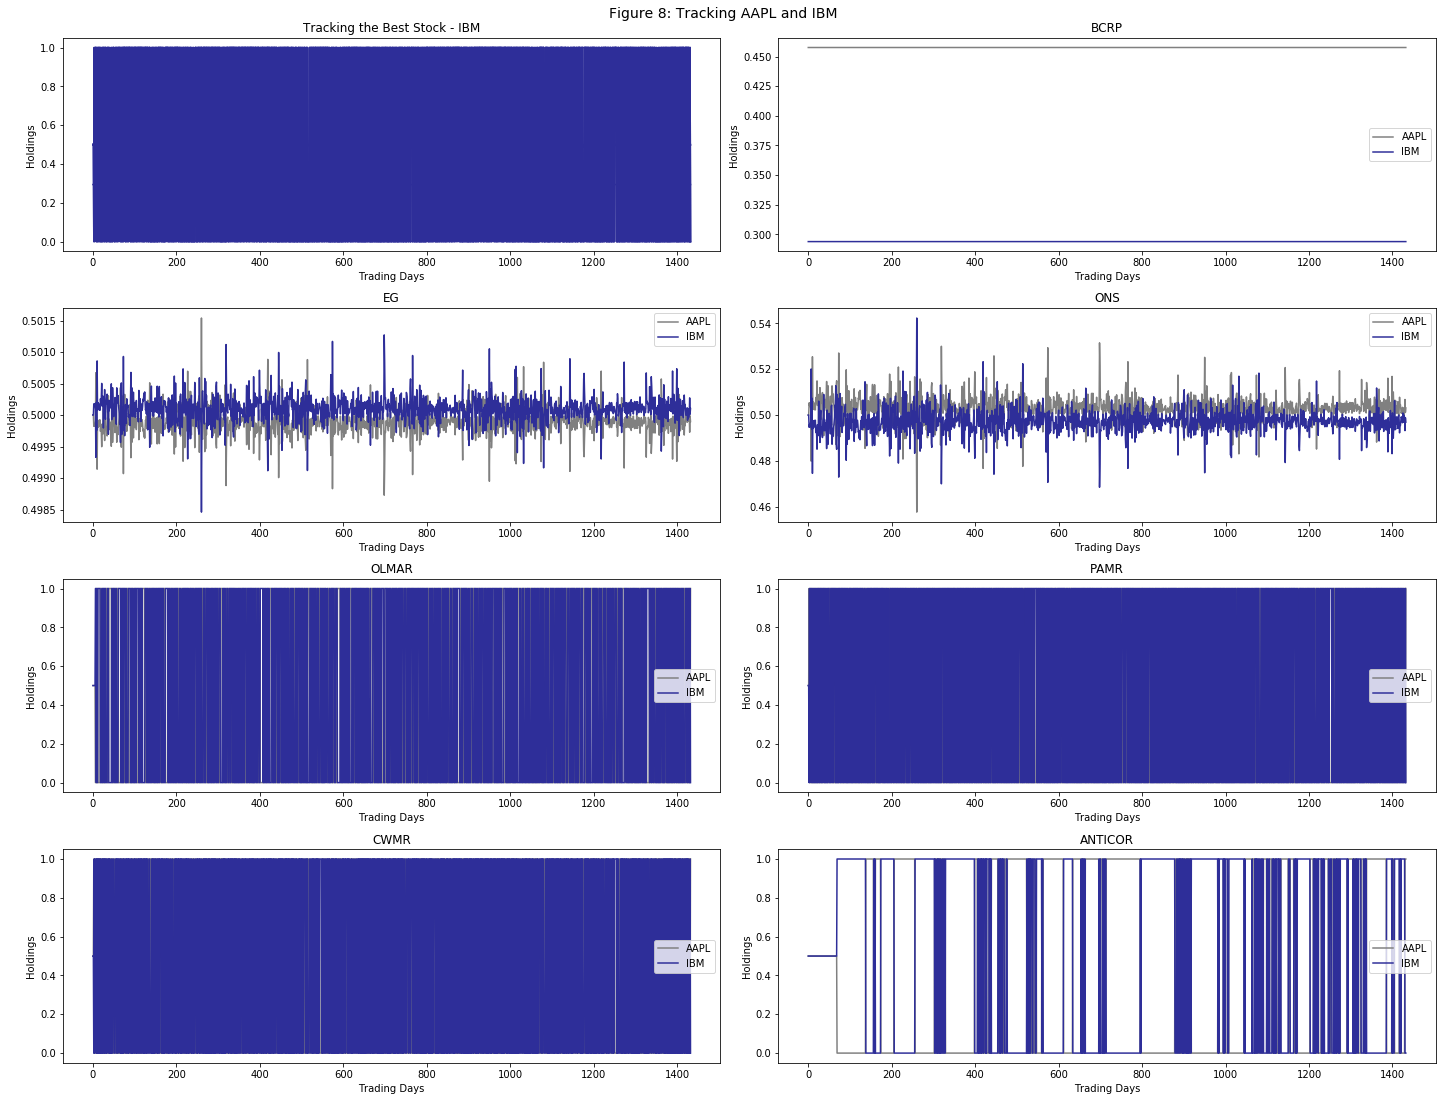

In [333]:
best_stock = 'IBM'
title = 'Figure 8: Tracking AAPL and IBM'
colors = ['grey', sns.light_palette("navy", reverse=True)[1]]
figsize = (20,15)
plot_weights(exp5_df, 
             best_stock = best_stock,
            title = title,
            colors = colors, 
            figsize = figsize)

#### Notes: 
- Major drawback of follow the loser algorithms is clearly that they trade too often. We can include this for illustrative purposes 

#### Experiment 6: Annual Returns for High and Low Volatility Stocks 

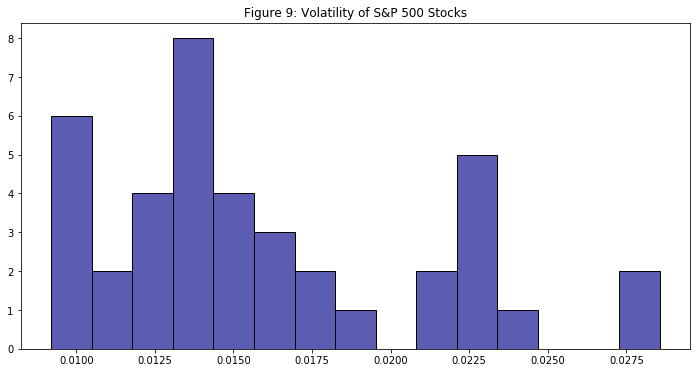

In [351]:
plt.figure(figsize = (12,6))
plt.hist(returns_df.std(axis = 0), bins = 15, ec = 'black', color = sns.light_palette("navy", reverse=True)[2])
plt.title('Figure 9: Volatility of S&P 500 Stocks')
plt.show()

In [350]:
### based on above histogram define a volatility threshold and partition data into high and low volatility data sets
n_stock = 10
high_vol = returns_df.loc[:,returns_df.std() > 0.02]
low_vol = returns_df.loc[:, returns_df.std() <= 0.0125]
low_vol = low_vol.iloc[:,0:n_stock]  # only need ten stocks in each data set 

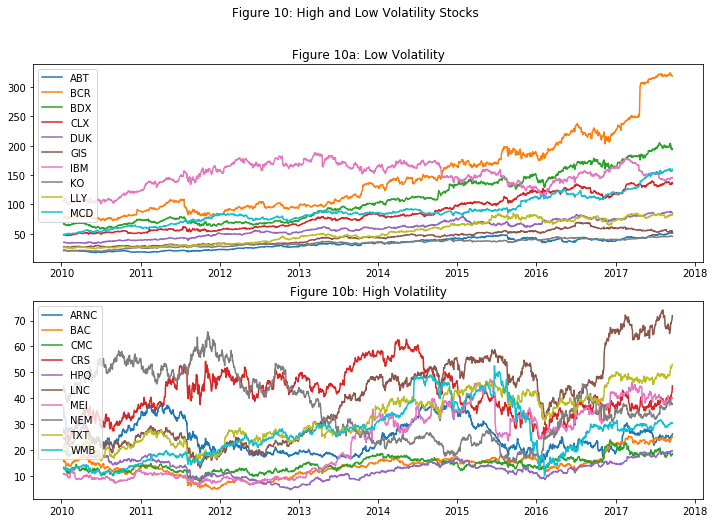

In [362]:
plt.figure(figsize = (12,8))
plt.suptitle('Figure 10: High and Low Volatility Stocks ')
plt.subplot(2,1,1)
plt.plot(price_df.loc[:, low_vol.columns])
plt.title('Figure 10a: Low Volatility')
plt.legend(low_vol.columns)
plt.subplot(2,1,2)
plt.plot(price_df.loc[:, high_vol.columns])
plt.title('Figure 10b: High Volatility')
plt.legend(high_vol.columns)
plt.show()

In [370]:
low_vol_res = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)
high_vol_res = pd.DataFrame(data = None, index = algorithms_col, columns = metrics)

In [374]:
# run main for loop on low and high volatility data sets 
for i in range(len(algorithms_col)):
    low_vol_res.loc[algorithms_col[i], 'results'] = algorithms[i].run(low_vol)
    high_vol_res.loc[algorithms_col[i], 'results'] = algorithms[i].run(high_vol)

2017-12-07 14:54:17,344 Running BCRP...
2017-12-07 14:54:17,441 BCRP finished successfully.
2017-12-07 14:54:17,466 Running BCRP...
2017-12-07 14:54:17,566 BCRP finished successfully.
2017-12-07 14:54:17,591 Running EG...
2017-12-07 14:54:17,602 Progress: 0%...
2017-12-07 14:54:17,887 Progress: 10%...
2017-12-07 14:54:18,161 Progress: 20%...
2017-12-07 14:54:18,434 Progress: 30%...
2017-12-07 14:54:18,693 Progress: 40%...
2017-12-07 14:54:18,946 Progress: 50%...
2017-12-07 14:54:19,211 Progress: 60%...
2017-12-07 14:54:19,506 Progress: 70%...
2017-12-07 14:54:19,808 Progress: 80%...
2017-12-07 14:54:20,088 Progress: 90%...
2017-12-07 14:54:20,359 EG finished successfully.
2017-12-07 14:54:20,381 Running EG...
2017-12-07 14:54:20,395 Progress: 0%...
2017-12-07 14:54:20,665 Progress: 10%...
2017-12-07 14:54:20,938 Progress: 20%...
2017-12-07 14:54:21,196 Progress: 30%...
2017-12-07 14:54:21,460 Progress: 40%...
2017-12-07 14:54:21,719 Progress: 50%...
2017-12-07 14:54:21,987 Progress: 60

In [375]:
low_vol_res = statistics(low_vol_res)
high_vol_res = statistics(high_vol_res)

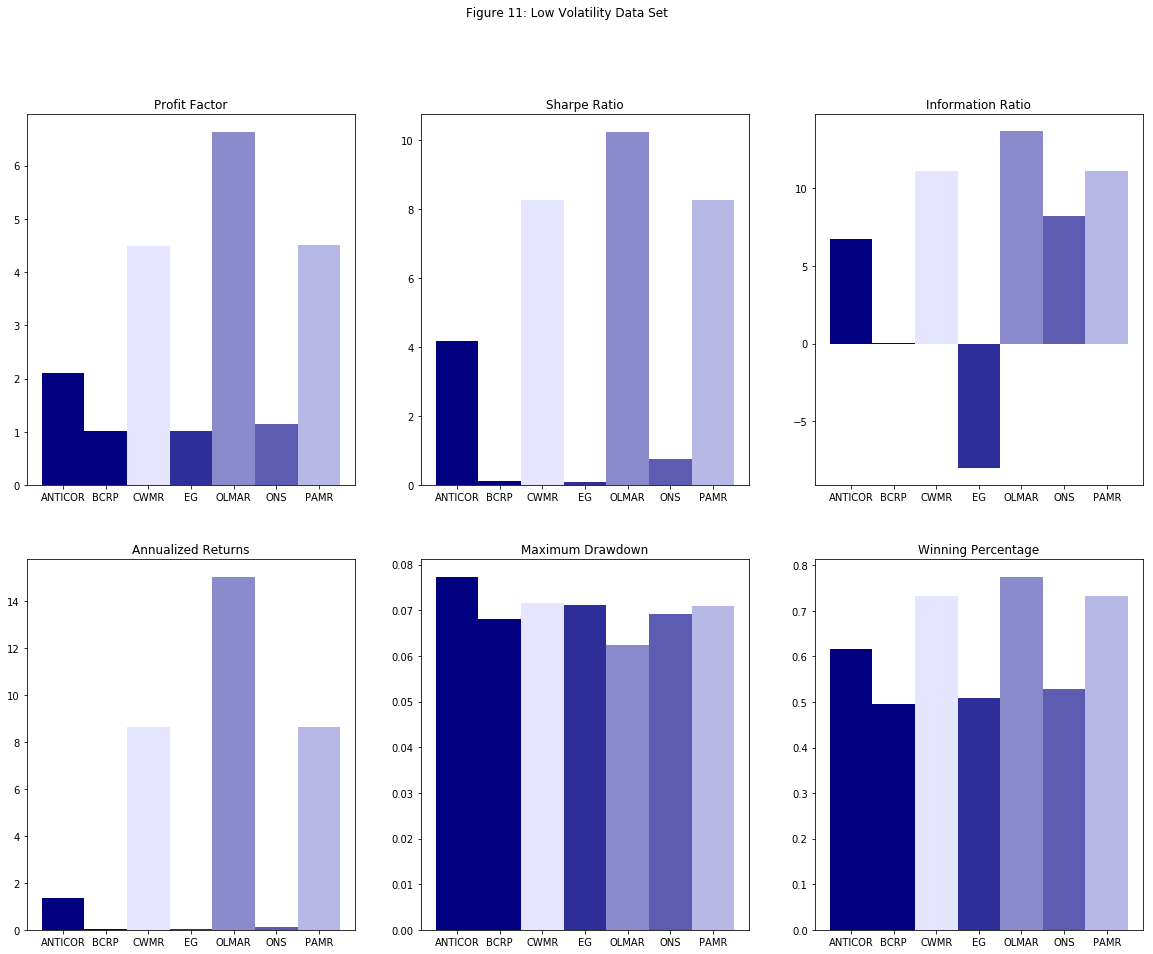

In [376]:
# plot results : low_vol_res, high_vol_res 
title = 'Figure 11: Low Volatility Data Set'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
results_plot(low_vol_res, title = title, sub_title = sub_title, figsize = (20,15))

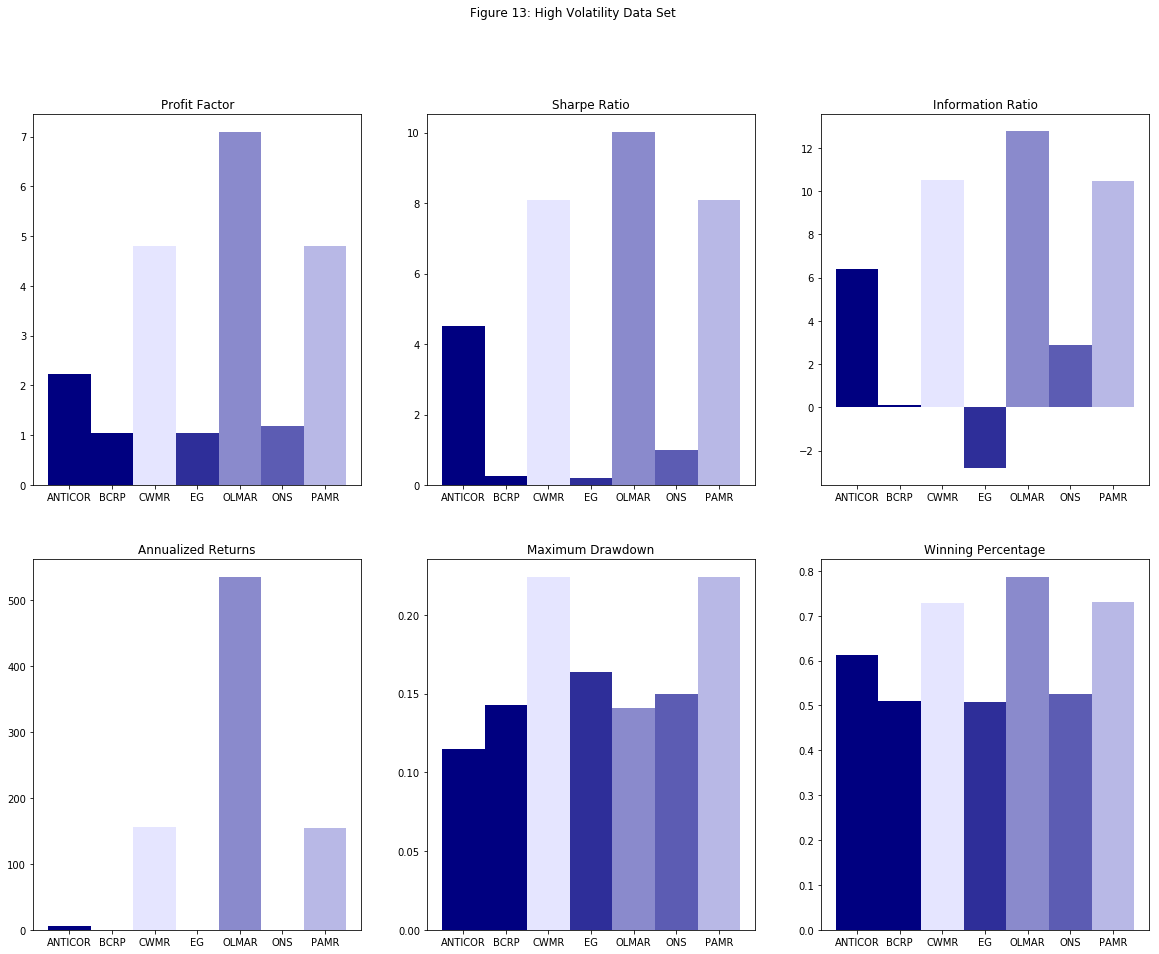

In [378]:
title = 'Figure 13: High Volatility Data Set'
sub_title = ['Profit Factor', 
             'Sharpe Ratio', 
             'Information Ratio', 
             'Annualized Returns', 
             'Maximum Drawdown',
            'Winning Percentage']
results_plot(high_vol_res, title = title, sub_title = sub_title, figsize = (20,15))